In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.stattools import coint 
import yfinance as yf

In [299]:
def cointegration_ptf(symbols, start = '2008-01-01', end = '2023-01-31', up = 1.2, down = -1.2):
  
  """symbols = Tickers of the companies, 2 names only.
     start = Starting date from which you wish to retrieve the data for the stocks, default: 2008-01-01
     end = End date for data retreving default: 2023-01-31
     up, bound = boundaries to show on the mean reversion graph
     This function aims that collecting the data, testing if the pair is cointegrated enough and compute the zscore
  """
  #Retrieving the data and computing the log returns
  df_prices = yf.download(tickers=symbols, start = start, end = end)['Adj Close']
  df_prices['Asset 1 Rets'] = np.log(df_prices[str(symbols[0])]).diff()
  df_prices['Asset 2 Rets'] = np.log(df_prices[str(symbols[1])]).diff()


  df_prices = df_prices.dropna()

  #Testing for cointegration by using the statsmodels library
  score, pvalue, crit_value = coint(df_prices['Asset 1 Rets'], df_prices['Asset 2 Rets'], trend = 'c', autolag = 'BIC')
  if pvalue > 0.1:
    return print('The pair is not cointegrated')
  else:
    #Computing the spread and z-score for the cointegrated pair, which we will use after to create the strategy 
    y = df_prices['Asset 1 Rets']
    x = df_prices['Asset 2 Rets']

    x = sm.add_constant(x)

    beta = sm.OLS(y, x).fit().params[0]

    df_prices['spread'] = (df_prices[str(symbols[0])] - beta*df_prices[str(symbols[1])]).to_frame('assets_spread')
    #Smoothing the spread and plotting it
    df_prices['zscore'] = (df_prices['spread'].rolling(window = 12).mean()-df_prices['spread'].rolling(window = 50).mean())/df_prices['spread'].rolling(window = 50).std()
    plt.figure(figsize = (16,6))
    plt.plot(df_prices['zscore'])
    plt.axhline(up, color='k', ls='-')
    plt.axhline(down, color='k', ls='-')
    plt.legend(['Zscore of the chosen pair'])
    plt.show()
    return df_prices


[*********************100%***********************]  2 of 2 completed


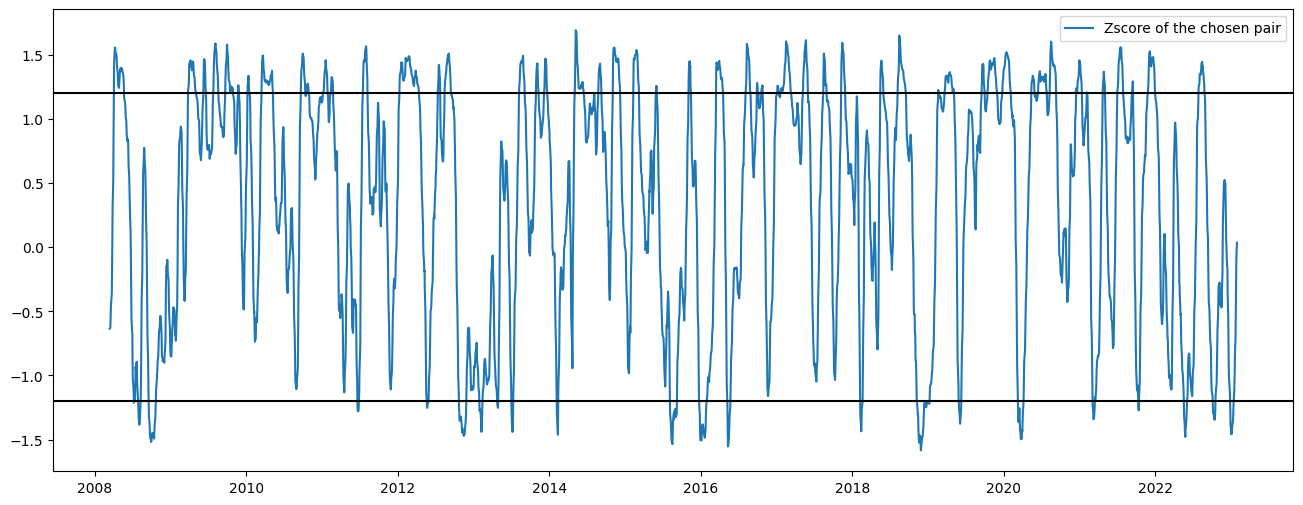

In [304]:
data = cointegration_ptf(['AAPL', 'GOOGL'])

In [308]:

def strategy(data, up_bound, down_bound):
  """This function aims at creating the strategy and returning the cumulative returns for it.
     data : retrieve the dataframe used in the previous function
     up_bound = upper bound for the signal. When the spread is above we short Asset 1 and long Asset 2
     down_bound = lower bound for the signal. When the spread is above we long Asset 1 and short Asset 2
  """
  data['signal'] = data['zscore'].apply(lambda x: 1 if (x>up_bound) else (-1 if (x<down_bound) else np.nan))
  data['signal'] = data['signal'].ffill()

  data['stratreturn'] = data.apply(lambda x: (x['Asset 1 Rets']-x['Asset 2 Rets']) if x['signal']==1 else ((x['Asset 2 Rets']-x['Asset 1 Rets']) if x['signal']==-1 else 0), axis=1)

  data = data.dropna()
  
  ptf_cum_rets = np.exp(np.log1p(data['stratreturn']).cumsum())

  plt.figure(figsize = (18,8))
  plt.plot(ptf_cum_rets)
  plt.legend(['Cumulative Returns of our startegy'])
  plt.show()


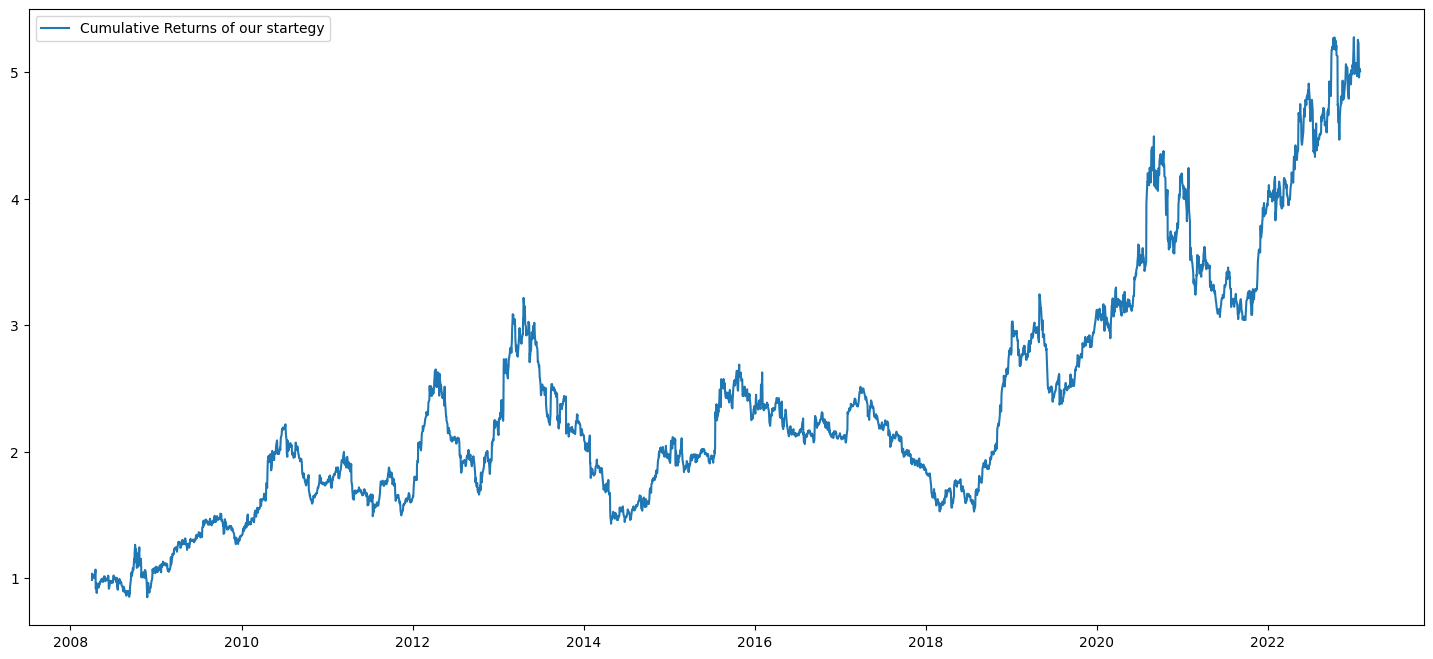

In [309]:
strategy(data, 0.8, -0.8)